 # Bank Account Fraud Detection under Extreme Class Imbalance

NeurIPS 2022 Dataset

In [ ]:
!curl -L -o bank-account-fraud-dataset-neurips-2022.zip https://www.kaggle.com/api/v1/datasets/download/sgpjesus/bank-account-fraud-dataset-neurips-2022

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  532M  100  532M    0     0   130M      0  0:00:04  0:00:04 --:--:--  141M


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report,roc_auc_score,average_precision_score, f1_score


from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
from zipfile import ZipFile
with ZipFile('/content/bank-account-fraud-dataset-neurips-2022.zip', 'r') as f:
  f.extractall()

In [ ]:
df = pd.read_csv('/content/Variant II.csv')
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.7,0.062288,-1,24,50,0.016740,-0.871747,AB,3430,...,1,200.0,0,INTERNET,6.804428,other,0,1,0,0
1,0,0.9,0.098433,-1,310,50,0.019002,-1.023805,AB,3492,...,1,1500.0,0,INTERNET,1.412211,macintosh,0,1,0,0
2,0,0.6,0.116962,-1,189,60,0.047064,-1.206121,AB,4621,...,0,200.0,0,INTERNET,14.488562,other,1,1,0,0
3,0,0.3,0.059078,10,40,60,0.008007,-0.075908,AA,1697,...,1,200.0,0,INTERNET,6.152497,linux,1,1,0,0
4,0,0.1,0.689959,-1,128,30,2.513544,-1.108190,AD,1431,...,0,200.0,0,INTERNET,5.599853,other,0,1,0,0


In [ ]:
df.shape

(1000000, 32)

In [ ]:
df.isna().sum()

,0
fraud_bool,0
income,0
name_email_similarity,0
prev_address_months_count,0
current_address_months_count,0
customer_age,0
days_since_request,0
intended_balcon_amount,0
payment_type,0
zip_count_4w,0


In [ ]:
df.nunique()

,0
fraud_bool,2
income,9
name_email_similarity,998708
prev_address_months_count,372
current_address_months_count,418
customer_age,9
days_since_request,989023
intended_balcon_amount,994785
payment_type,5
zip_count_4w,6315


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.011029,0.104438,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,1000000.0,0.574544,0.288768,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,1000000.0,0.488628,0.291431,5.024707e-08,0.214787,0.489745,0.754373,1.000000
prev_address_months_count,1000000.0,14.824523,43.231383,-1.000000e+00,-1.000000,-1.000000,-1.000000,399.000000
current_address_months_count,1000000.0,99.381393,94.558757,-1.000000e+00,26.000000,64.000000,154.000000,429.000000
customer_age,1000000.0,41.304140,13.804710,1.000000e+01,30.000000,50.000000,50.000000,90.000000
days_since_request,1000000.0,0.911917,4.986861,3.112791e-08,0.007430,0.015650,0.026928,76.577505
intended_balcon_amount,1000000.0,8.638806,20.573558,-1.573989e+01,-1.178013,-0.831185,0.078508,112.702504
zip_count_4w,1000000.0,1567.400554,1009.619023,1.000000e+00,901.000000,1236.000000,1909.000000,6650.000000
velocity_6h,1000000.0,5685.095489,3001.707767,-1.741097e+02,3470.243411,5408.425641,7653.990129,16801.339834


Domain-Aware Feature Cleaning

In [ ]:
df.drop(columns=['device_fraud_count'],axis=1,inplace=True)

In [ ]:
cols = ["intended_balcon_amount", "credit_risk_score"]

for c in cols:
    print(c)
    print(df[c].value_counts().head())


intended_balcon_amount
intended_balcon_amount
-1.876409    3
-0.493148    3
-0.443237    3
-1.335378    3
-0.615764    3
Name: count, dtype: int64
credit_risk_score
credit_risk_score
110    6533
113    6508
108    6460
112    6454
116    6407
Name: count, dtype: int64


Feature Engineering (Missingness as Signal)

In [ ]:
# Negative intended balance flag
df["intended_balcon_negative"] = (df["intended_balcon_amount"] < 0).astype(int)

In [ ]:
# Credit risk score: negative values indicate missing
df["credit_risk_score_missing"] = (df["credit_risk_score"] < 0).astype(int)
df.loc[df["credit_risk_score"] < 0, "credit_risk_score"] = np.nan

In [ ]:
cols = [
    'prev_address_months_count',
    'current_address_months_count',
    'bank_months_count',
    'session_length_in_minutes',
    'device_distinct_emails_8w',
]
df[cols] = df[cols].replace(-1, np.nan)

In [ ]:
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month,intended_balcon_negative,credit_risk_score_missing
0,0,0.7,0.062288,NaN,24.0,50,0.016740,-0.871747,AB,3430,...,200.0,0,INTERNET,6.804428,other,0,1.0,0,1,0
1,0,0.9,0.098433,NaN,310.0,50,0.019002,-1.023805,AB,3492,...,1500.0,0,INTERNET,1.412211,macintosh,0,1.0,0,1,0
2,0,0.6,0.116962,NaN,189.0,60,0.047064,-1.206121,AB,4621,...,200.0,0,INTERNET,14.488562,other,1,1.0,0,1,0
3,0,0.3,0.059078,10.0,40.0,60,0.008007,-0.075908,AA,1697,...,200.0,0,INTERNET,6.152497,linux,1,1.0,0,1,0
4,0,0.1,0.689959,NaN,128.0,30,2.513544,-1.108190,AD,1431,...,200.0,0,INTERNET,5.599853,other,0,1.0,0,1,0


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.011029,0.104438,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,1000000.0,0.574544,0.288768,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,1000000.0,0.488628,0.291431,5.024707e-08,0.214787,0.489745,0.754373,1.000000
prev_address_months_count,240585.0,64.775185,66.954188,6.000000e+00,26.000000,36.000000,87.000000,399.000000
current_address_months_count,996512.0,99.732749,94.537094,0.000000e+00,27.000000,64.000000,155.000000,429.000000
customer_age,1000000.0,41.304140,13.804710,1.000000e+01,30.000000,50.000000,50.000000,90.000000
days_since_request,1000000.0,0.911917,4.986861,3.112791e-08,0.007430,0.015650,0.026928,76.577505
intended_balcon_amount,1000000.0,8.638806,20.573558,-1.573989e+01,-1.178013,-0.831185,0.078508,112.702504
zip_count_4w,1000000.0,1567.400554,1009.619023,1.000000e+00,901.000000,1236.000000,1909.000000,6650.000000
velocity_6h,1000000.0,5685.095489,3001.707767,-1.741097e+02,3470.243411,5408.425641,7653.990129,16801.339834


Replace Encoded Missing Values

In [ ]:
missing_flag_cols = [
    'prev_address_months_count',
    'current_address_months_count',
    'bank_months_count',
    'session_length_in_minutes',
    'device_distinct_emails_8w'
]

for c in missing_flag_cols:
    df[f"{c}_missing"] = df[c].isna().astype(int)

In [ ]:
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,keep_alive_session,device_distinct_emails_8w,month,intended_balcon_negative,credit_risk_score_missing,prev_address_months_count_missing,current_address_months_count_missing,bank_months_count_missing,session_length_in_minutes_missing,device_distinct_emails_8w_missing
0,0,0.7,0.062288,NaN,24.0,50,0.016740,-0.871747,AB,3430,...,0,1.0,0,1,0,1,0,0,0,0
1,0,0.9,0.098433,NaN,310.0,50,0.019002,-1.023805,AB,3492,...,0,1.0,0,1,0,1,0,0,0,0
2,0,0.6,0.116962,NaN,189.0,60,0.047064,-1.206121,AB,4621,...,1,1.0,0,1,0,1,0,0,0,0
3,0,0.3,0.059078,10.0,40.0,60,0.008007,-0.075908,AA,1697,...,1,1.0,0,1,0,0,0,0,0,0
4,0,0.1,0.689959,NaN,128.0,30,2.513544,-1.108190,AD,1431,...,0,1.0,0,1,0,1,0,0,0,0


Missing Indicator Flags

In [ ]:
flag_cols = [c for c in df.columns if c.endswith("_missing")]

df.groupby(flag_cols[0])["fraud_bool"].mean()

,fraud_bool
credit_risk_score_missing,
0,0.011131
1,0.003250


In [ ]:
for c in flag_cols:
    rate = df.groupby(c)["fraud_bool"].mean()
    print(c, rate.to_dict())

credit_risk_score_missing {0: 0.011130855172246108, 1: 0.0032497678737233053}
prev_address_months_count_missing {0: 0.00275993931458736, 1: 0.013648663774089267}
current_address_months_count_missing {0: 0.011059575800391767, 1: 0.0022935779816513763}
bank_months_count_missing {0: 0.009304497393579976, 1: 0.0164343123635642}
session_length_in_minutes_missing {0: 0.011029113290963524, 1: 0.010979358805445762}
device_distinct_emails_8w_missing {0: 0.011025704636757951, 1: 0.020833333333333332}


In [ ]:
df['fraud_bool'].value_counts()

,count
fraud_bool,
0,988971
1,11029


Target Distribution (Extreme Imbalance)

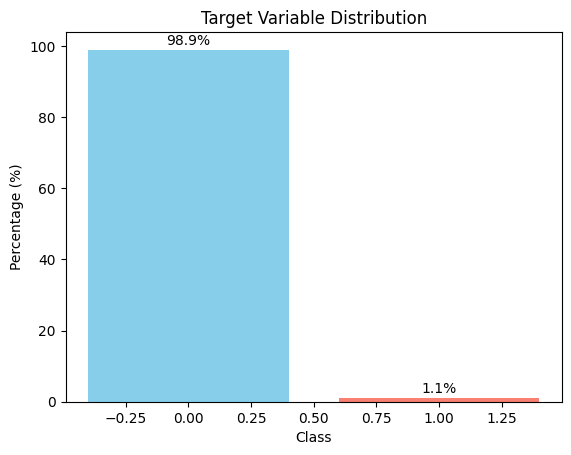

In [ ]:
import matplotlib.pyplot as plt

percentages = df['fraud_bool'].value_counts(normalize=True).sort_index() * 100

colors = ['#87CEEB', '#FA8072']

plt.figure()
bars = plt.bar(percentages.index, percentages.values, color=colors)

plt.ylabel('Percentage (%)')
plt.xlabel('Class')
plt.title('Target Variable Distribution')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,
        f"{height:.1f}%",
        ha='center',
        va='bottom'
    )

plt.show()


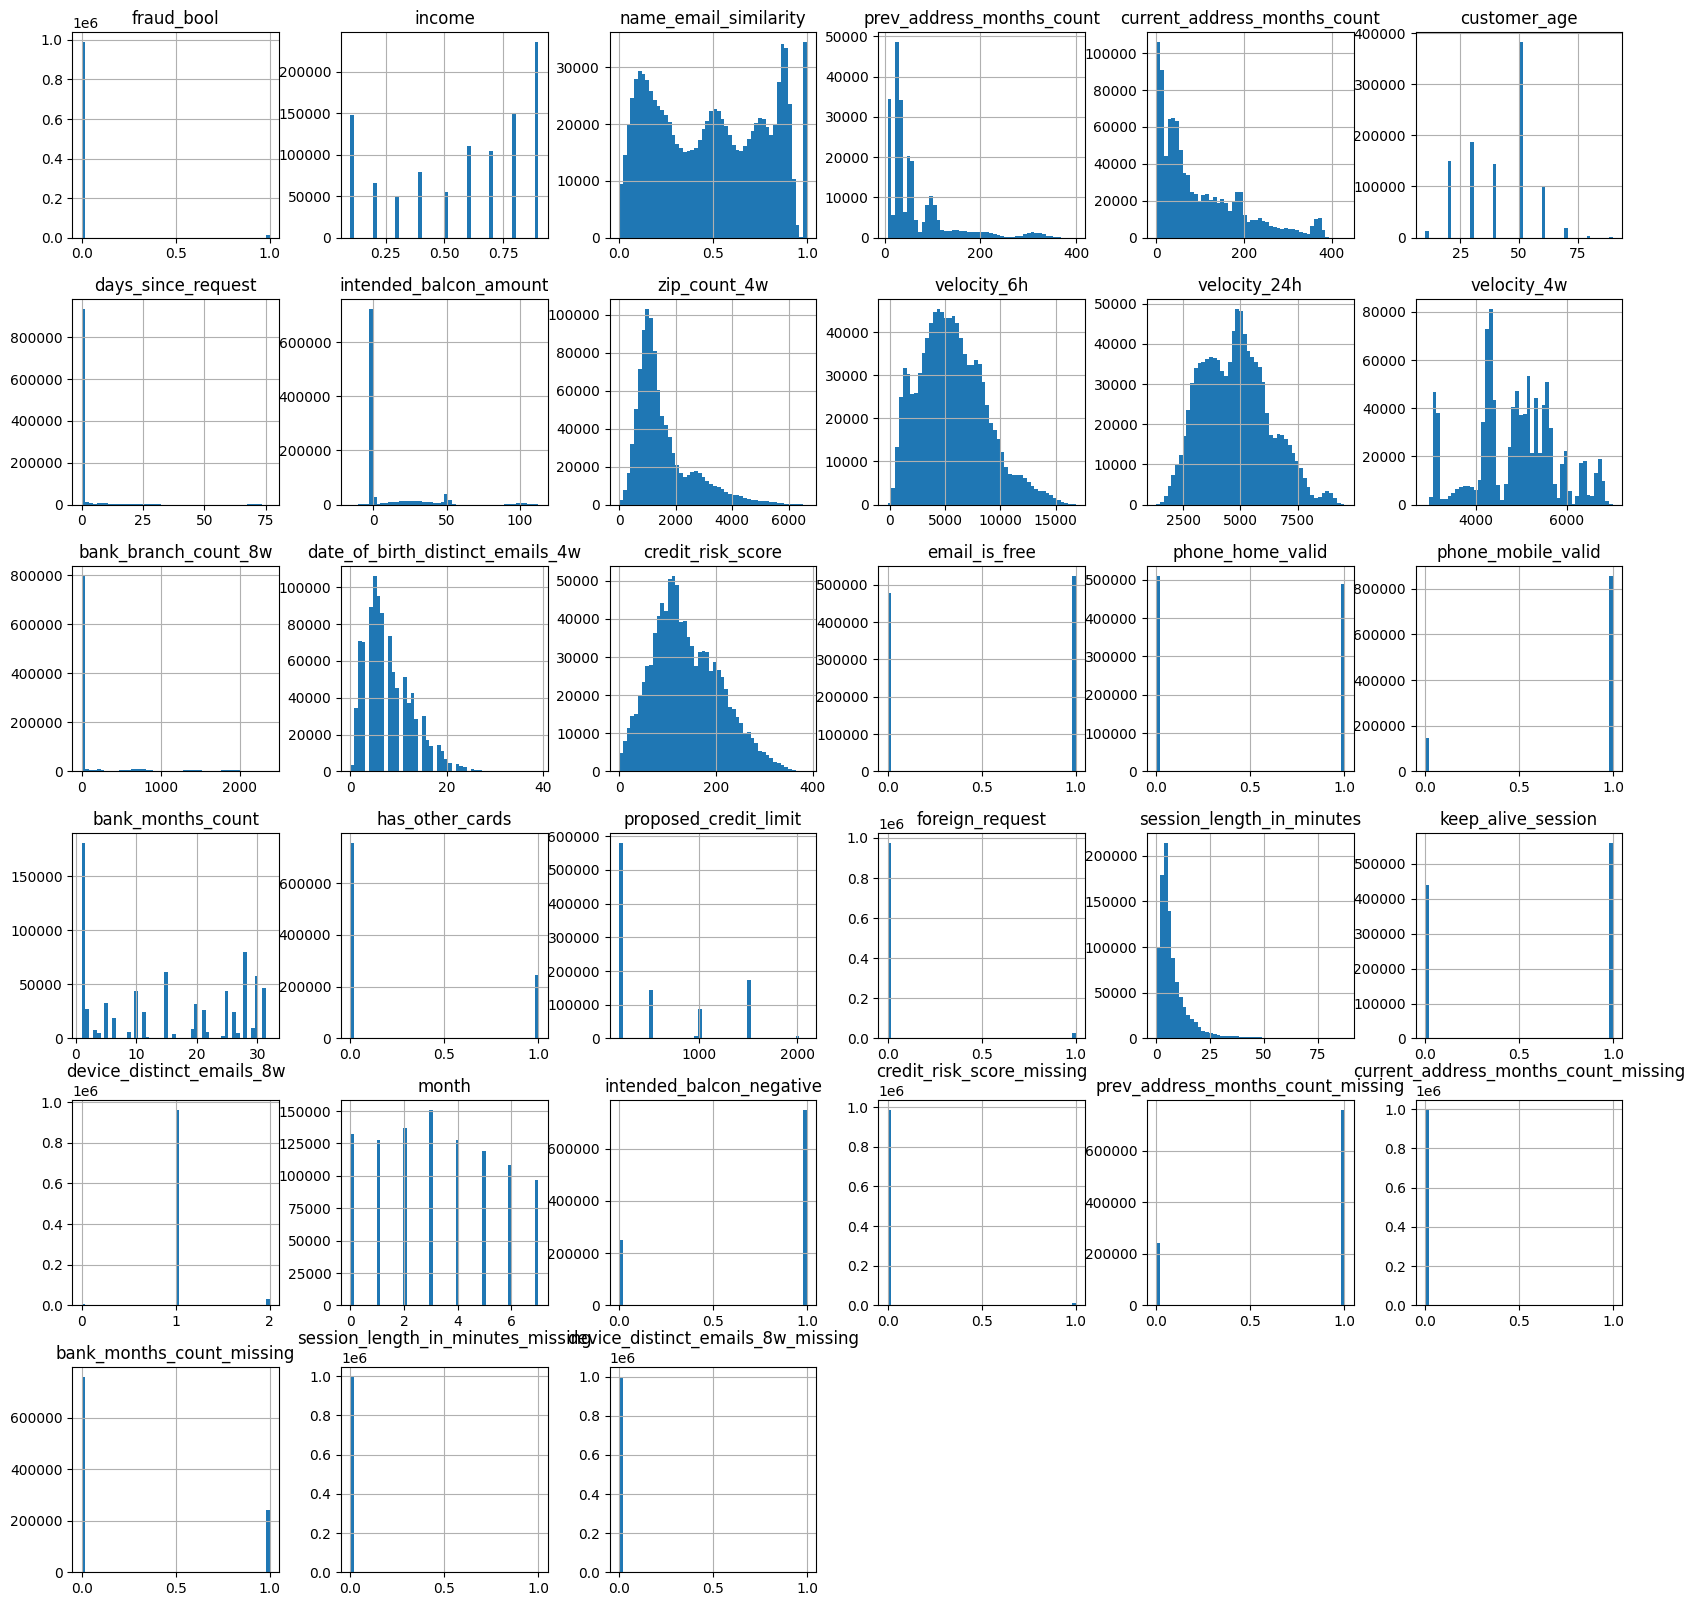

In [ ]:
df.hist(figsize=(20, 20),bins=50)
plt.show();

Train / Test Split

In [ ]:
X= df.drop(columns=['fraud_bool'])
y= df['fraud_bool'].copy()

In [ ]:
y.mean()

np.float64(0.011029)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [ ]:
y_train.mean(),y_test.mean()

(np.float64(0.01102875), np.float64(0.01103))

Feature Groups

In [ ]:
numeric_no_log = [
    "income",
    "name_email_similarity",
    "customer_age",
    "credit_risk_score",
    "zip_count_4w",
    "bank_months_count",
    "date_of_birth_distinct_emails_4w",
    "proposed_credit_limit",
]

log_cols = [
    "days_since_request",
    "velocity_6h",
    "velocity_24h",
    "velocity_4w",
    "bank_branch_count_8w",
    "session_length_in_minutes",
]

special_log_cols = ["intended_balcon_amount"]

binary_cols = [
    "email_is_free",
    "phone_home_valid",
    "phone_mobile_valid",
    "has_other_cards",
    "foreign_request",
    "keep_alive_session",
    "intended_balcon_negative",
    "credit_risk_score_missing",
    "prev_address_months_count_missing",
    "current_address_months_count_missing",
    "bank_months_count_missing",
    "session_length_in_minutes_missing",
    "device_distinct_emails_8w_missing",
]

categorical_cols = [
    "payment_type",
    "employment_status",
    "housing_status",
    "device_os",
    "source",
    "month",
]


Preprocessing Pipelines

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

log_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scaler", StandardScaler())
])
#Safe Log Transformer
def safe_log1p(x):
    x = np.nan_to_num(x, nan=0.0)        # NaN → 0
    x = np.clip(x, a_min=0, a_max=None)  # negative → 0
    return np.log1p(x)

log_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(safe_log1p, feature_names_out="one-to-one")),
    ("scaler", StandardScaler())
])

binary_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_no_log),
        ("log", log_transformer, log_cols),
        ("special_log", log_transformer, special_log_cols),
        ("bin", binary_transformer, binary_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop"
)


In [ ]:
Xt = preprocessor.fit_transform(X_train)

print("Nan?", np.isnan(Xt).any())


Nan? False


In [ ]:
Xt_num = numeric_transformer.fit_transform(X_train[numeric_no_log])
print("numeric_no_log NaN:", np.isnan(Xt_num).any())

numeric_no_log NaN: False


In [ ]:
Xt_log = log_transformer.fit_transform(X_train[log_cols])
print("log_cols NaN:", np.isnan(Xt_log).any())

log_cols NaN: False


In [ ]:
Xt_spec = log_transformer.fit_transform(X_train[log_transformer])
print("special_log NaN:", np.isnan(Xt_spec).any())


KeyError: Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('log',
                 FunctionTransformer(feature_names_out='one-to-one',
                                     func=<function safe_log1p at 0x7825ab05cc20>)),
                ('scaler', StandardScaler())])

In [ ]:
Xt_cat = categorical_transformer.fit_transform(X_train[categorical_cols])
print("categorical_cols NaN:", np.isnan(Xt_cat).any())


categorical_cols NaN: False


Model Tuning Helper

In [ ]:
from sklearn.model_selection import GridSearchCV

def tune_model(pipe, param_grid):
  grid = GridSearchCV(
      pipe,
      param_grid,
      scoring="average_precision",
      cv=2,
      n_jobs=-1,
      verbose=1
  )
  grid.fit(X_train, y_train)
  return grid.best_estimator_

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Model #1 Logistic Regression

In [ ]:
logreg_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

logreg_params = {
    "clf__C": [0.1, 1]
}

best_logreg = tune_model(logreg_pipe, logreg_params)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


# Model #2 Random Forest

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=42
    ))
])

rf_param_grid = {
    "clf__n_estimators": [100],
    "clf__max_depth": [10],
    "clf__min_samples_leaf": [50]
}

best_rf = tune_model(rf_pipe, rf_param_grid)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


# Model #3 XGB BOOST

In [ ]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier


scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", XGBClassifier(
        tree_method="hist",
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,
        random_state=42
    ))
])

xgb_param_grid = {
    "clf__n_estimators": [100],
    "clf__max_depth": [3, 4],
    "clf__learning_rate": [0.05]
}

best_xgb = tune_model(xgb_pipe, xgb_param_grid)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


#Model Comparison

In [ ]:
import pandas as pd
from sklearn.metrics import (
    classification_report,
    f1_score,
    roc_auc_score,
    average_precision_score
)

models = {
    "Logistic Regression": best_logreg,
    "Random Forest": best_rf,
    "XGBoost": best_xgb
}

results = []

for name, model in models.items():

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    report = classification_report(
        y_test,
        y_pred,
        output_dict=True,
        zero_division=0
    )

    results.append({
        "Model": name,
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob),
        "PR-AUC": average_precision_score(y_test, y_prob)
    })

results_df = (
    pd.DataFrame(results)
    .sort_values(by="PR-AUC", ascending=False)
    .reset_index(drop=True)
)

results_df


,Model,Precision,Recall,F1-score,ROC-AUC,PR-AUC
0,XGBoost,0.045034,0.803717,0.085290,0.890006,0.163240
1,Logistic Regression,0.044485,0.824569,0.084416,0.890735,0.144061
2,Random Forest,0.051387,0.737987,0.096084,0.879937,0.141027


Among the evaluated models, XGBoost achieved the highest PR-AUC and ROC-AUC, indicating superior ranking and discrimination performance under severe class imbalance. Although precision at the default threshold remained low across all models, this behavior is expected in rare-event prediction tasks and can be mitigated through decision threshold optimization.

In [ ]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)


best_xgb.fit(X_tr, y_tr)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['income',
                                                   'name_email_similarity',
                                                   'customer_age',
                                                   'credit_risk_score',
                                                   'zip_count_4w',
                                                   'bank_months_count',
                                                   'date_of_birth_distinct_emails_4w',
                                                   'proposed_credit_limit']),
                                                 ('log',
                                                  Pipeline(steps=[('impute...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None, ...))])

Threshold Optimization

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

y_val_prob = best_xgb.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0.01, 0.5, 50)

rows = []

for t in thresholds:
    y_pred_t = (y_val_prob >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred_t, zero_division=0),
        "recall": recall_score(y_val, y_pred_t),
        "f1": f1_score(y_val, y_pred_t)
    })

threshold_df = pd.DataFrame(rows)
threshold_df.sort_values("f1", ascending=False).head(10)


,threshold,precision,recall,f1
49,0.50,0.045926,0.818130,0.086970
48,0.49,0.044732,0.826062,0.084869
47,0.48,0.043602,0.832295,0.082863
46,0.47,0.042629,0.843059,0.081154
45,0.46,0.041524,0.849858,0.079179
44,0.45,0.040351,0.854391,0.077063
43,0.44,0.039140,0.858357,0.074867
42,0.43,0.038108,0.864589,0.072999
41,0.42,0.037008,0.869688,0.070996
40,0.41,0.035939,0.873654,0.069038


In [ ]:
best_threshold = threshold_df.loc[
    threshold_df["f1"].idxmax(), "threshold"
]

best_threshold


np.float64(0.5)

#Final Evaluation:

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

y_test_prob = best_xgb.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob >= best_threshold).astype(int)

print(classification_report(y_test, y_test_pred, zero_division=0))

print("ROC-AUC:", roc_auc_score(y_test, y_test_prob))
print("PR-AUC:", average_precision_score(y_test, y_test_prob))


              precision    recall  f1-score   support

           0       1.00      0.81      0.89    197794
           1       0.05      0.81      0.09      2206

    accuracy                           0.81    200000
   macro avg       0.52      0.81      0.49    200000
weighted avg       0.99      0.81      0.89    200000

ROC-AUC: 0.8899266983733574
PR-AUC: 0.1610431669115252


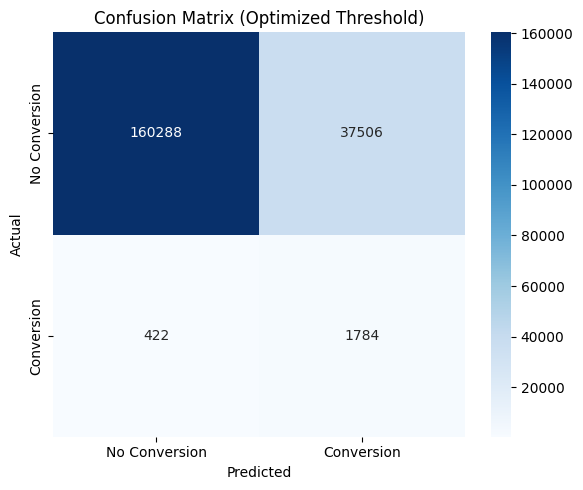

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# final predictions
y_test_prob = best_xgb.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob >= best_threshold).astype(int)

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Conversion", "Conversion"],
    yticklabels=["No Conversion", "Conversion"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Optimized Threshold)")
plt.tight_layout()
plt.show()


Using an optimized decision threshold, the XGBoost model captured approximately 81% of all conversions while targeting less than 20% of the customer base. This resulted in a more than fourfold lift over the baseline conversion rate, demonstrating substantial improvements in marketing efficiency and cost control.

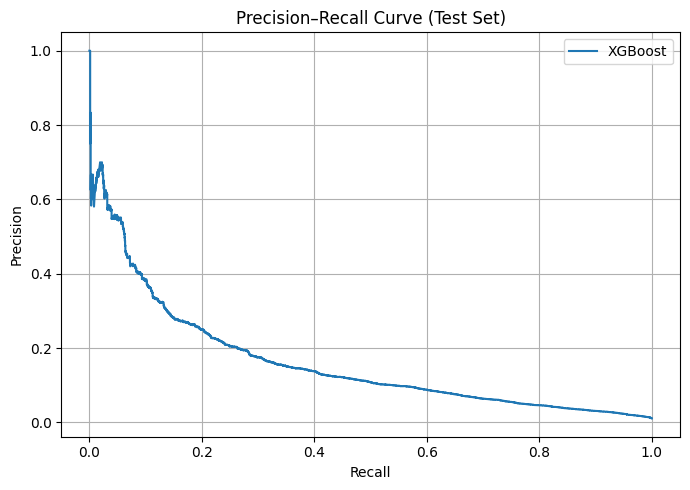

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label="XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


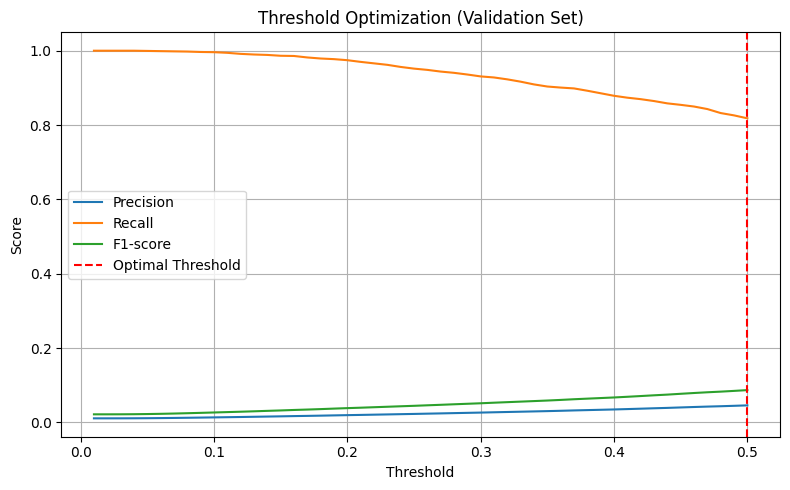

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(threshold_df["threshold"], threshold_df["precision"], label="Precision")
plt.plot(threshold_df["threshold"], threshold_df["recall"], label="Recall")
plt.plot(threshold_df["threshold"], threshold_df["f1"], label="F1-score")

plt.axvline(best_threshold, color="red", linestyle="--", label="Optimal Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Optimization (Validation Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


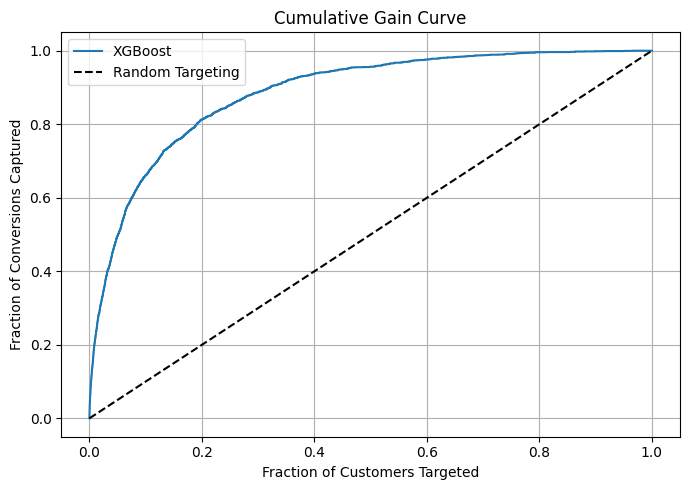

In [ ]:
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt

y_prob = best_xgb.predict_proba(X_test)[:, 1]

# sort by predicted probability
order = np.argsort(y_prob)[::-1]
y_sorted = y_test.values[order]

cum_conversions = np.cumsum(y_sorted)
total_conversions = y_sorted.sum()

percent_customers = np.arange(1, len(y_sorted)+1) / len(y_sorted)
gain = cum_conversions / total_conversions

plt.figure(figsize=(7,5))
plt.plot(percent_customers, gain, label="XGBoost")
plt.plot([0,1], [0,1], 'k--', label="Random Targeting")
plt.xlabel("Fraction of Customers Targeted")
plt.ylabel("Fraction of Conversions Captured")
plt.title("Cumulative Gain Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


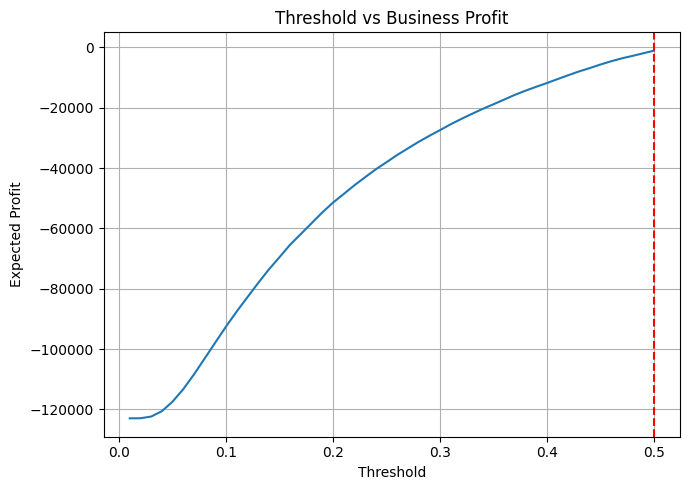

In [ ]:
cost_fp = 1
gain_tp = 20

profits = []

for _, row in threshold_df.iterrows():
    tp = row["recall"] * y_val.sum()
    fp = tp * (1/row["precision"] - 1) if row["precision"] > 0 else 0
    profit = tp * gain_tp - fp * cost_fp
    profits.append(profit)

threshold_df["profit"] = profits

plt.figure(figsize=(7,5))
plt.plot(threshold_df["threshold"], threshold_df["profit"])
plt.axvline(best_threshold, color="red", linestyle="--")
plt.xlabel("Threshold")
plt.ylabel("Expected Profit")
plt.title("Threshold vs Business Profit")
plt.grid(True)
plt.tight_layout()
plt.show()


Explainability (SHAP)

In [ ]:
import shap

X_test_transformed = best_xgb.named_steps["prep"].transform(X_test)

explainer = shap.TreeExplainer(best_xgb.named_steps["clf"])
shap_values = explainer.shap_values(X_test_transformed)


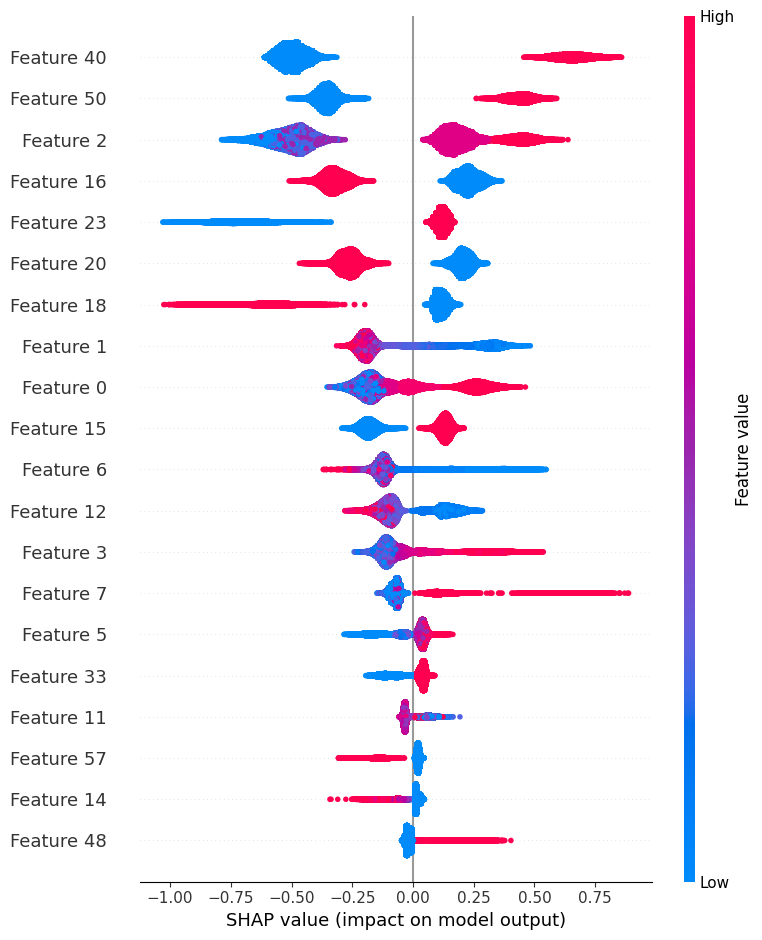

In [ ]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    show=True
)

SHAP analysis reveals that recent behavioral intensity and activity-related features dominate the model’s decision process. Several features exhibit asymmetric effects, where high values significantly increase conversion likelihood while others act as risk indicators when elevated. This highlights the importance of non-linear modeling and interaction-aware learning in conversion prediction tasks.

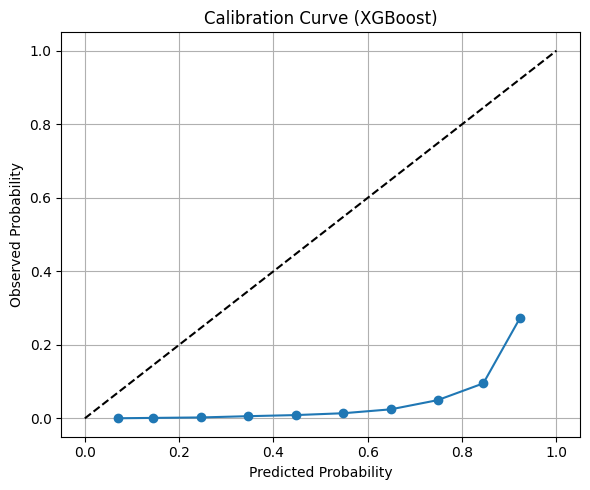

In [ ]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
    y_test, y_test_prob, n_bins=10
)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Probability")
plt.title("Calibration Curve (XGBoost)")
plt.grid(True)
plt.tight_layout()
plt.show()


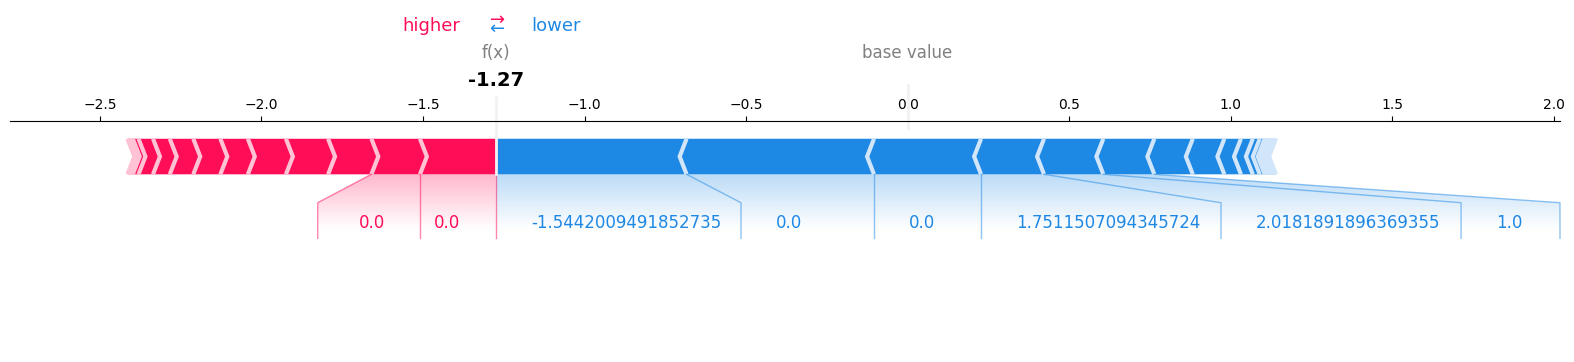

In [ ]:
idx = 0  # random customer
shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_test_transformed[idx],
    matplotlib=True
)


SHAP analysis revealed that behavioral velocity features and recent activity indicators were the strongest drivers of conversion probability, providing interpretable and actionable insights for marketing decision-makers.

In [ ]:
!pip install -q lime
import importlib
importlib.invalidate_caches()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Local Explanation (LIME)

In [ ]:
import lime
import lime.lime_tabular

X_train_transformed = best_xgb.named_steps["prep"].transform(X_train)

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_transformed,
    mode="classification",
    feature_names=None,
    class_names=["No Conversion", "Conversion"],
    discretize_continuous=True
)


In [ ]:
idx = 0
exp = explainer.explain_instance(
    X_test_transformed[idx],
    best_xgb.named_steps["clf"].predict_proba,
    num_features=10
)

exp.show_in_notebook(show_table=True)
